# Pipeline_for_recognition_of_Russian_handwritten_text

In [1]:
import sys

import cv2
from matplotlib import pyplot as plt
import numpy as np

from huggingface_hub import hf_hub_download

from segm.predictor import SegmPredictor

In [2]:
#IMG_PATH = "input_text_2.jpg"
IMG_PATH = "input_text_1.jpg"

MODEL_PATH = "segm_model.ckpt"
CONFIG_PATH = "segm_segm_config.json"

NUM_THREADS = 8

#DEVICE = 'cuda'
DEVICE = 'cpu'

RUNTIME = 'Pytorch'

In [3]:
predictor = SegmPredictor(
    model_path=MODEL_PATH,
    config_path=CONFIG_PATH,
    num_threads=NUM_THREADS,
    device=DEVICE,
    runtime=RUNTIME
)

C:\Users\Илья\AppData\Roaming\Python\Python38\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Илья\AppData\Roaming\Python\Python38\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [4]:
image = cv2.imread(IMG_PATH)

pred_data = predictor([image])

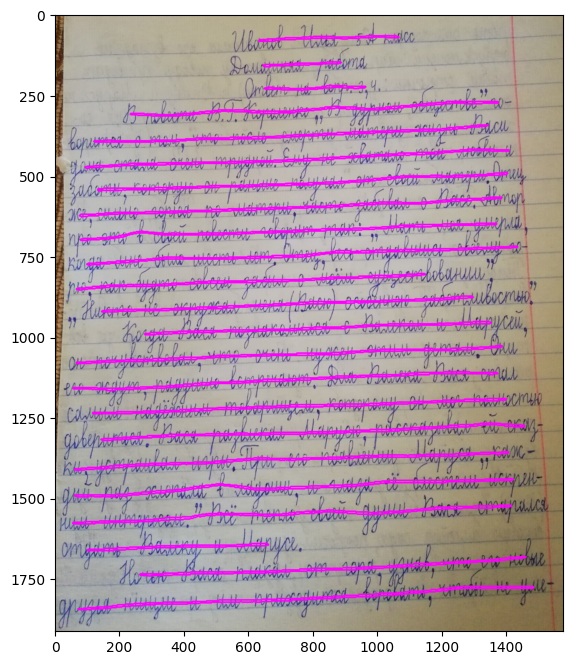

In [5]:
pred_img = pred_data[0]

image = cv2.imread(IMG_PATH)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
for prediction in pred_img['predictions']:
    if prediction['class_name'] == 'text_line':
      contour = prediction['polygon']
      cv2.drawContours(image, np.array([contour]), -1, (255, 0, 255), 3)

plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.show()

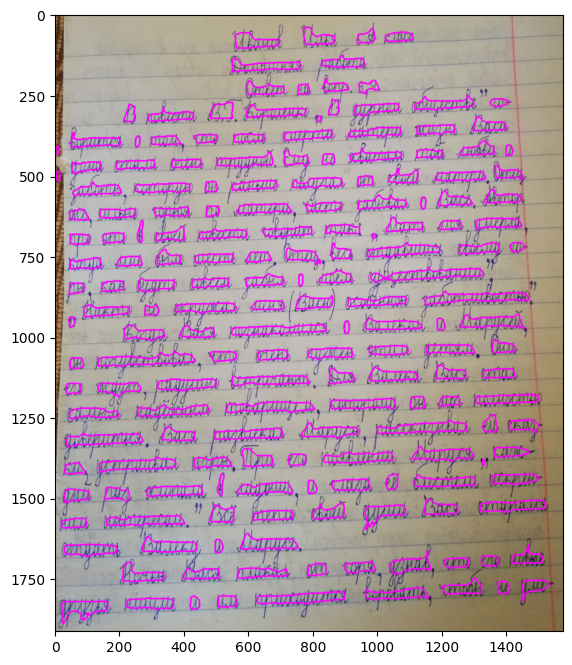

In [6]:
pred_img = pred_data[0]

image = cv2.imread(IMG_PATH)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
for prediction in pred_img['predictions']:
    if prediction['class_name'] == 'shrinked_text':
      contour = prediction['polygon']
      cv2.drawContours(image, np.array([contour]), -1, (255, 0, 255), 3)

plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.show()

# Применение модели-трансформера

In [7]:
import sys
!pip install easyocr
import easyocr
from PIL import Image
import cv2
import numpy as np
import os
import math
import torch
from torch import nn
from torch.nn import Conv2d, MaxPool2d, BatchNorm2d, LeakyReLU
from torchvision import transforms
import matplotlib.pyplot as plt
import editdistance
import warnings
warnings.filterwarnings('ignore')
import cv2
import numpy as np

Defaulting to user installation because normal site-packages is not writeable


In [8]:
def intersects(rect, line):
    # Получаем координаты x и y первой и последней точек прямоугольника
    x1, y1, x2, y2 = rect
    rect_x = [x1, x2, x2, x1]  # Вершины x
    rect_y = [y1, y1, y2, y2]  # Вершины y

    # Проверяем, пересекается ли линия с прямоугольником
    for point in line:
        if (x1 <= point[0] <= x2) and (y1 <= point[1] <= y2):
            return True
    return False

def main(IMG_PATH, pred_data, expansion=12):
    # Получение координат из предсказанных данных
    pred_img = pred_data[0]
    letter_coordinates = []
    line_coordinates = []

    for prediction in pred_img['predictions']:
        if prediction['class_name'] == 'shrinked_text':
            contour = prediction['polygon']
            # Получаем прямоугольник, описывающий многоугольник
            x_coords = [point[0] for point in contour]
            y_coords = [point[1] for point in contour]
            min_x, min_y = min(x_coords) - expansion, min(y_coords) - expansion
            max_x, max_y = max(x_coords) + expansion, max(y_coords) + expansion
            letter_coordinates.append((min_x, min_y, max_x, max_y))
        elif prediction['class_name'] == 'text_line':
            contour = prediction['polygon']
            line_coordinates.insert(0, contour)  # Вставляем в начало списка, чтобы начать с верхней строки

    # Отрисовка контуров на изображении
    image = cv2.imread(IMG_PATH)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Отрисовка линий и выделение многоугольников
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (255, 0, 255), (0, 255, 255)]  # Список цветов для линий
    num_colors = len(colors)
    rectangle_counter = 0  # Счетчик прямоугольников на каждой линии
    
    # Список для сохранения координат прямоугольников в правильном порядке
    reordered_coordinates = []

    for i, line_contour in enumerate(line_coordinates):
        color_index = i % num_colors  # Повторяем цвета, если линий больше, чем цветов
        cv2.polylines(image, [np.array(line_contour)], isClosed=False, color=colors[color_index], thickness=2)
        
        # Сортировка прямоугольников на линии по x-координате верхнего левого угла
        letter_coordinates_on_line = sorted([rect for rect in letter_coordinates if intersects(rect, line_contour)], key=lambda rect: rect[0])

        # Нумерация и отрисовка прямоугольников
        for rect in letter_coordinates_on_line:
            x1, y1, x2, y2 = rect
            cv2.rectangle(image, (x1, y1), (x2, y2), color=colors[color_index], thickness=2)
            # Вывод номера прямоугольника
            cv2.putText(image, str(rectangle_counter), (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, colors[color_index], 2)
            rectangle_counter += 1
            # Добавляем координаты прямоугольника в список в правильном порядке
            reordered_coordinates.append(rect)

    # Вывод изображения с контурами и линиями
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.savefig('temp_image.png')
    plt.show()
    

    return reordered_coordinates

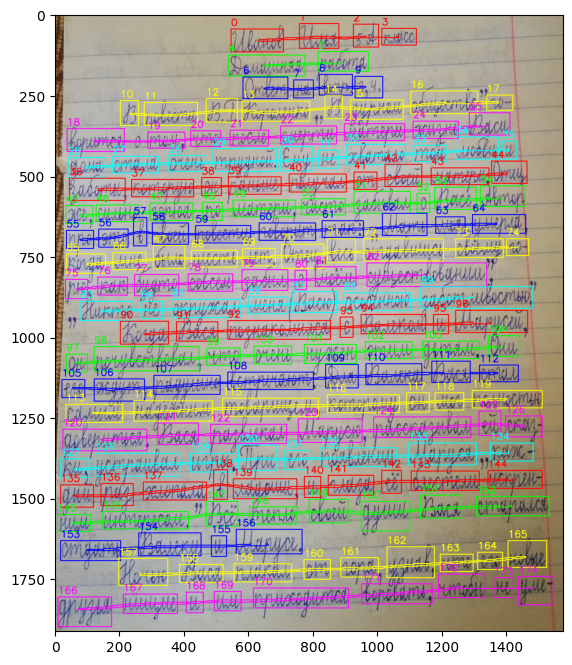

[(545, 43, 707, 114), (757, 26, 879, 103), (924, 28, 1002, 99), (1012, 41, 1119, 93), (537, 124, 774, 189), (815, 113, 971, 174), (582, 192, 721, 259), (739, 201, 800, 257), (818, 184, 921, 248), (929, 190, 1015, 257), (202, 265, 258, 342), (276, 271, 441, 342), (468, 259, 564, 332), (579, 267, 789, 329), (836, 250, 890, 321), (915, 263, 1078, 323), (1102, 235, 1309, 306), (1337, 248, 1418, 295), (37, 352, 214, 423), (287, 363, 402, 413), (420, 359, 513, 408), (542, 357, 661, 406), (699, 344, 872, 400), (896, 337, 1083, 389), (1109, 329, 1249, 383), (1283, 303, 1409, 372), (40, 442, 156, 504), (178, 438, 321, 490), (350, 436, 466, 485), (489, 414, 686, 485), (699, 408, 796, 483), (816, 419, 877, 475), (903, 401, 1085, 464), (1109, 404, 1214, 455), (1241, 378, 1374, 447), (1385, 391, 1430, 447), (44, 506, 217, 575), (237, 510, 429, 564), (454, 504, 515, 560), (537, 502, 700, 556), (725, 493, 902, 549), (926, 487, 997, 541), (1022, 463, 1136, 532), (1165, 474, 1344, 526), (1352, 453, 146

In [9]:
letter_coordinates = main(IMG_PATH, pred_data)
print(letter_coordinates)

In [10]:
MODEL = 'model2' #выбранная архитектура или вариант модели, которая будет использоваться при обучении

HIDDEN = 512#количество нейронов в каждом СКРЫТОМ слое модели
ENC_LAYERS = 2#кол-во слоёв в кодирующей части модели
DEC_LAYERS = 2#кол-во слоёв в декодирующей части модели
N_HEADS = 4#Эта переменная определяет количество голов внимания (attention heads), которые будут использоваться в модели. Это часто связано с многоголовым механизмом внимания в трансформерных моделях.

LENGTH = 42#ожидаемая длина входной или выходной последовательности данных.

ALPHABET = ['PAD', 'SOS', ' ', '!', '"', '%', '(', ')', ',', '-', '.', '/',
            '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?',
            '[', ']', '«', '»', 'А', 'Б', 'В', 'Г', 'Д', 'Е', 'Ж', 'З', 'И',
            'Й', 'К', 'Л', 'М', 'Н', 'О', 'П', 'Р', 'С', 'Т', 'У', 'Ф', 'Х',
            'Ц', 'Ч', 'Ш', 'Щ', 'Э', 'Ю', 'Я', 'а', 'б', 'в', 'г', 'д', 'е',
            'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т',
            'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я',
            'ё', 'EOS']#
'''
пояснение токенов:
Символы 'PAD', 'SOS' и 'EOS' являются специальными токенами, которые часто используются при обработке последовательных данных, таких как текст. Вот их значения и назначения:

'PAD' - Этот токен обычно используется для заполнения пустых мест в последовательностях, чтобы привести их к одной и той же длине. Например, если у вас есть несколько предложений разной длины, и вы хотите обрабатывать их как мини-пакеты (батчи) данных, то 'PAD' используется для заполнения конца более коротких предложений, чтобы сделать их одной длины с самым длинным предложением в пакете. Это полезно при обучении моделей, таких как рекуррентные нейронные сети (RNN) или трансформеры, которые работают с последовательными данными фиксированной длины.

'SOS' - Этот токен представляет собой "начало последовательности" (Start Of Sequence) и обычно используется в задачах машинного обучения, связанных с генерацией последовательностей. Он обозначает начало генерации или декодирования последовательности данных. Например, в задачах генерации текста 'SOS' может быть добавлен в начале генерируемого текста, чтобы указать, что началась генерация.

'EOS' - Этот токен представляет собой "конец последовательности" (End Of Sequence) и обычно используется в задачах машинного обучения, связанных с генерацией последовательностей. Он обозначает конец генерации или декодирования последовательности данных. Например, в задачах генерации текста 'EOS' может быть добавлен в конец генерируемого текста, чтобы указать, что генерация завершилась.
'''
### TRAINING ## Настройки для обучения
BATCH_SIZE = 16#Эта переменная задает размер пакета (batch size), который будет использоваться при обучении модели. Это количество примеров данных, которое будет обрабатываться за одну итерацию обучения.
DROPOUT = 0.2#Препятствие переобучению модели, её зацикливанию, сильному заострению внимания на определённых нейронах (паттернах изображения) за счёт СЛУЧАЙНОЙ (каждый раз нейроны, которые будут заморожены, выбираются млучайным образом) заморозки нейронов, препятствованию обновлению весов этих нейронов в каждой эпохе обучения. Значение DROPOUT равное 0.2 означает, что в каждой эпохе обучения примерно 20% нейронов будет "выключено" или "заморожено" с определенной вероятностью. Точная вероятность может варьироваться в зависимости от реализации, но обычно она находится в диапазоне от 0.2 до 0.5.
#Цель Dropout: Целью Dropout является предотвращение переобучения. Когда нейроны случайно отключаются, это заставляет сеть учиться более устойчивым и робастным признакам, а не зависеть слишком сильно от конкретных нейронов. Это помогает сети лучше обобщать знания на новые данные.
N_EPOCHS = 128#Эта переменная определяет количество эпох (итераций) обучения модели
CHECKPOINT_FREQ = 1 # save checkpoint every 10 epochs#Эта переменная указывает частоту сохранения контрольных точек (checkpoints) модели, обычно в виде весов модели. В данном случае, контрольные точки будут сохраняться каждую эпоху.
DEVICE = 'cpu:0' # or torch.device('cuda' if torch.cuda.is_available() else 'cpu')#обучаем на CPU
RANDOM_SEED = 42#Это позволяет получать одни и те же результаты при многократном выполнении кода.
SCHUDULER_ON = True # "ReduceLROnPlateau"#Эта переменная указывает, будет ли использоваться планировщик (scheduler) при обучении модели. Планировщик может изменять скорость обучения (learning rate) в процессе обучения.
PATIENCE = 5 # for ReduceLROnPlateau#Если используется планировщик, то это значение указывает на терпимость (параметр терпимости) для изменения скорости обучения. Если качество модели не улучшается в течение указанного количества эпох, скорость обучения может быть уменьшена.
OPTIMIZER_NAME = 'Adam' # or "SGD"#Эта переменная определяет выбранный оптимизатор для обновления параметров модели в процессе обучения. В данном случае, будет использоваться оптимизатор Adam.
LR = 2e-6#Эта переменная задает начальную скорость обучения (learning rate) для оптимизатора. Это значение определяет, насколько большие шаги будут предприниматься при обновлении параметров модели в каждой итерации обучения.


WIDTH = 256#ширина изображения в пикселях
HEIGHT = 64#высота изображения в пикселях
CHANNELS = 1#количество каналов в изображение (черно-белое или сине-белое изображение и тп)

class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = torch.nn.Dropout(p=dropout)
        self.scale = torch.nn.Parameter(torch.ones(1))

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(
            0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.scale * self.pe[:x.size(0), :]
        return self.dropout(x)


def process_data(image_dir, labels_dir, ignore=[]):
    """
    params
    ---
    image_dir : str
      path to directory with images
    labels_dir : str
      path to tsv file with labels
    returns
    ---
    img2label : dict
      keys are names of images and values are correspondent labels
    chars : list
      all unique chars used in data
    all_labels : list
    """

    chars = []
    img2label = dict()

    raw = open(labels_dir, 'r', encoding='utf-8').read()
    temp = raw.split('\n')
    for t in temp:
        try:
            x = t.split('\t')
            flag = False
            for item in ignore:
                if item in x[1]:
                    flag = True
            if flag == False:
                img2label[image_dir + x[0]] = x[1]
                for char in x[1]:
                    if char not in chars:
                        chars.append(char)
        except:
            pass

    all_labels = sorted(list(set(list(img2label.values()))))
    chars.sort()
    chars = ['PAD', 'SOS'] + chars + ['EOS']

    return img2label, chars, all_labels


def indicies_to_text(indexes, idx2char):
    text = "".join([idx2char[i] for i in indexes])
    text = text.replace('EOS', '').replace('PAD', '').replace('SOS', '')
    return text


def char_error_rate(p_seq1, p_seq2):
    """
    params
    ---
    p_seq1 : str
    p_seq2 : str
    returns
    ---
    cer : float
    """
    p_vocab = set(p_seq1 + p_seq2)
    p2c = dict(zip(p_vocab, range(len(p_vocab))))
    c_seq1 = [chr(p2c[p]) for p in p_seq1]
    c_seq2 = [chr(p2c[p]) for p in p_seq2]
    return editdistance.eval(''.join(c_seq1),
                             ''.join(c_seq2)) / max(len(c_seq1), len(c_seq2))


def process_image(img):
    """
    params:
    ---
    img : np.array
    returns
    ---
    img : np.array
    """
    w, h, _ = img.shape
    new_w = HEIGHT
    new_h = int(h * (new_w / w))
    img = cv2.resize(img, (new_h, new_w))
    w, h, _ = img.shape

    img = img.astype('float32')

    new_h = WIDTH
    if h < new_h:
        add_zeros = np.full((w, new_h - h, 3), 255)
        img = np.concatenate((img, add_zeros), axis=1)

    if h > new_h:
        img = cv2.resize(img, (new_h, new_w))

    return img


# MAKE PREDICTION
def prediction(model, file_path, boxs, idx2char):
    main_im = Image.open(file_path).convert('RGB')
    preds = []
    model.eval()

    with torch.no_grad():
        for coor in boxs:
            [A, B, C, D] = coor
            img = main_im.crop((A, B, C, D))

            img = process_image(np.asarray(img)).astype('uint8')
            img = img / img.max()
            img = np.transpose(img, (2, 0, 1))

            src = torch.FloatTensor(img).unsqueeze(0).to(DEVICE)
            if CHANNELS == 1:
                src = transforms.Grayscale(CHANNELS)(src)
            out_indexes = model.predict(src)
            pred = indicies_to_text(out_indexes[0], idx2char)
            preds.append(pred)

    return preds


class ToTensor(object):
    def __init__(self, X_type=None, Y_type=None):
        self.X_type = X_type

    def __call__(self, X):
        X = X.transpose((2, 0, 1))
        X = torch.from_numpy(X)
        if self.X_type is not None:
            X = X.type(self.X_type)
        return X


# plot images
def show_img_grid(images, labels, N):
    n = int(N ** (0.5))
    k = 0
    f, axarr = plt.subplots(n, n, figsize=(10, 10))
    for i in range(n):
        for j in range(n):
            axarr[i, j].set_title(labels[k])
            axarr[i, j].imshow(images[k])
            k += 1


class TransformerModel(nn.Module):
    def __init__(self, outtoken, hidden, enc_layers=1, dec_layers=1, nhead=1, dropout=0.1):
        super(TransformerModel, self).__init__()

        self.enc_layers = enc_layers
        self.dec_layers = dec_layers
        self.backbone_name = 'conv(64)->conv(64)->conv(128)->conv(256)->conv(256)->conv(512)->conv(512)'

        self.conv0 = Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv1 = Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv2 = Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 1), padding=(1, 1))
        self.conv3 = Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv4 = Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 1), padding=(1, 1))
        self.conv5 = Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv6 = Conv2d(512, 512, kernel_size=(2, 1), stride=(1, 1))

        self.pool1 = MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        self.pool3 = MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        self.pool5 = MaxPool2d(kernel_size=(2, 2), stride=(2, 1), padding=(0, 1), dilation=1, ceil_mode=False)

        self.bn0 = BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.bn1 = BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.bn2 = BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.bn3 = BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.bn4 = BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.bn5 = BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.bn6 = BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

        self.activ = LeakyReLU()

        self.pos_encoder = PositionalEncoding(hidden, dropout)
        self.decoder = nn.Embedding(outtoken, hidden)
        self.pos_decoder = PositionalEncoding(hidden, dropout)
        self.transformer = nn.Transformer(d_model=hidden, nhead=nhead, num_encoder_layers=enc_layers,
                                          num_decoder_layers=dec_layers, dim_feedforward=hidden * 4, dropout=dropout)

        self.fc_out = nn.Linear(hidden, outtoken)
        self.src_mask = None
        self.trg_mask = None
        self.memory_mask = None

    def generate_square_subsequent_mask(self, sz):
        mask = torch.triu(torch.ones(sz, sz, device=DEVICE), 1)
        mask = mask.masked_fill(mask == 1, float('-inf'))
        return mask

    def make_len_mask(self, inp):
        return (inp == 0).transpose(0, 1)

    def _get_features(self, src):
        '''
        params
        ---
        src : Tensor [64, 3, 64, 256] : [B,C,H,W]
            B - batch, C - channel, H - height, W - width
        returns
        ---
        x : Tensor : [W,B,CH]
        '''
        x = self.activ(self.bn0(self.conv0(src)))
        x = self.pool1(self.activ(self.bn1(self.conv1(x))))
        x = self.activ(self.bn2(self.conv2(x)))
        x = self.pool3(self.activ(self.bn3(self.conv3(x))))
        x = self.activ(self.bn4(self.conv4(x)))
        x = self.pool5(self.activ(self.bn5(self.conv5(x))))
        x = self.activ(self.bn6(self.conv6(x)))
        x = x.permute(0, 3, 1, 2).flatten(2).permute(1, 0, 2)
        return x

    def predict(self, batch):
        '''
        params
        ---
        batch : Tensor [64, 3, 64, 256] : [B,C,H,W]
            B - batch, C - channel, H - height, W - width

        returns
        ---
        result : List [64, -1] : [B, -1]
            preticted sequences of tokens' indexes
        '''
        result = []
        for item in batch:
            x = self._get_features(item.unsqueeze(0))
            memory = self.transformer.encoder(self.pos_encoder(x))
            out_indexes = [ALPHABET.index('SOS'), ]
            for i in range(100):
                trg_tensor = torch.LongTensor(out_indexes).unsqueeze(1).to(DEVICE)
                output = self.fc_out(self.transformer.decoder(self.pos_decoder(self.decoder(trg_tensor)), memory))

                out_token = output.argmax(2)[-1].item()
                out_indexes.append(out_token)
                if out_token == ALPHABET.index('EOS'):
                    break
            result.append(out_indexes)
        return result

    def forward(self, src, trg):
        '''
        params
        ---
        src : Tensor [64, 3, 64, 256] : [B,C,H,W]
            B - batch, C - channel, H - height, W - width
        trg : Tensor [13, 64] : [L,B]
            L - max length of label
        '''
        if self.trg_mask is None or self.trg_mask.size(0) != len(trg):
            self.trg_mask = self.generate_square_subsequent_mask(len(trg)).to(trg.device)

        x = self._get_features(src)
        src_pad_mask = self.make_len_mask(x[:, :, 0])
        src = self.pos_encoder(x)
        trg_pad_mask = self.make_len_mask(trg)
        trg = self.decoder(trg)
        trg = self.pos_decoder(trg)

        output = self.transformer(src, trg, src_mask=self.src_mask, tgt_mask=self.trg_mask,
                                  memory_mask=self.memory_mask,
                                  src_key_padding_mask=src_pad_mask, tgt_key_padding_mask=trg_pad_mask,
                                  memory_key_padding_mask=src_pad_mask)
        output = self.fc_out(output)

        return output

WEIGHTS_PATH = 'config/test.pt'

In [11]:
model = TransformerModel(len(ALPHABET), hidden=HIDDEN, enc_layers=ENC_LAYERS, dec_layers=DEC_LAYERS,
                         nhead=N_HEADS, dropout=DROPOUT).to(DEVICE)
model.load_state_dict(torch.load(WEIGHTS_PATH, map_location=torch.device('cpu')))
char2idx = {char: idx for idx, char in enumerate(ALPHABET)}
idx2char = {idx: char for idx, char in enumerate(ALPHABET)}
preds = prediction(model, IMG_PATH, letter_coordinates, idx2char)
print(preds)

['Иванов', 'Илья', '5А', 'класс', 'Домашняя', 'работа', 'Ответ', 'на', 'вопр.', '3.4.', 'В', 'повести', 'В.Г.', 'Короленко', 'В', 'дурном', 'обществе', 'го-', 'ворится', 'том.', 'что', 'после', 'смерти', 'матери', 'жизнь', 'Васи', 'дома', 'стала', 'очень', 'трудной.', 'Ему', 'не', 'хватало', 'той', 'любви', 'и', 'заботы', 'которую', 'он', 'раньше', 'получал', 'от', 'своей', 'матери.', 'Отец', 'же,', 'сильно', 'горюя', 'по', 'матери.', 'часто', 'забывал', '0', 'Васе.', 'Автор', 'про', 'это', 'в', 'своей', 'повести', 'говорит', 'так.', 'Мать', 'моя', 'умерла', 'когда', 'мне', 'было', 'шесть', 'лет,', 'Отец', 'весь', 'отдавшись', 'своему', 'го-', 'рю', 'как', 'будто', 'совсем', 'забыл', 'О', 'моём', 'существовании', 'Никто', 'не', 'окружал', 'меня', 'Васю', 'особенного', 'заботливостью', 'Когда', 'Вася', 'познакомился', 'С', 'Валеком', 'И', 'Марусей,', 'он', 'почувствовал', 'что', 'очень', 'нужен', 'этим', 'детям.', 'Они', 'его', 'ждут', 'радушно', 'встречают', 'Для', 'Валека', 'Вося', 'с

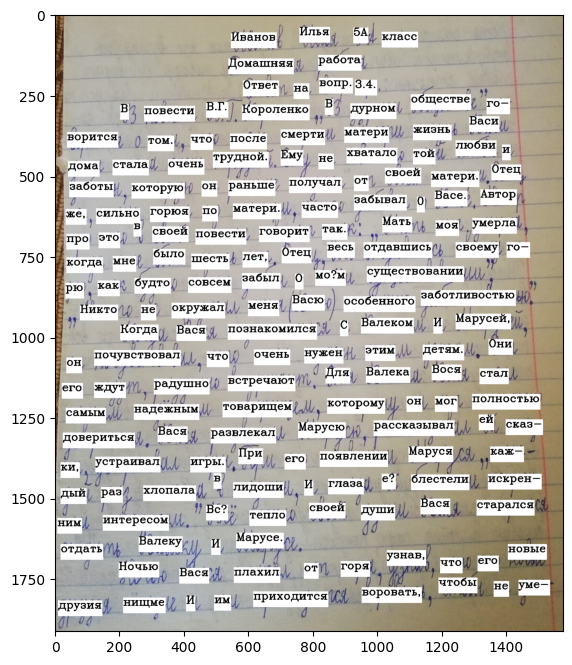

In [12]:
# Прочитайте изображение
image = cv2.imread(IMG_PATH)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Наложите текст на изображение для каждой пары координат
font = cv2.FONT_HERSHEY_COMPLEX
font_scale = 1.1
font_thickness = 2
background_color = (255, 255, 255)
font_color = (0, 0, 0)

for idx, coordinates in enumerate(letter_coordinates):
    text = preds[idx]  # Предполагается, что preds - это список символов
    text_coordinates = (coordinates[0], coordinates[1] + 35)
    
    (text_width, text_height), _ = cv2.getTextSize(text, font, font_scale, font_thickness)
    cv2.rectangle(image, (text_coordinates[0], text_coordinates[1] - text_height),
                  (text_coordinates[0] + text_width, text_coordinates[1] + text_height), background_color, -1)
    cv2.putText(image, text, text_coordinates, font, font_scale, font_color, font_thickness)

# Отобразите изображение
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.savefig('temp_image.png', bbox_inches='tight', pad_inches=0)
plt.show()

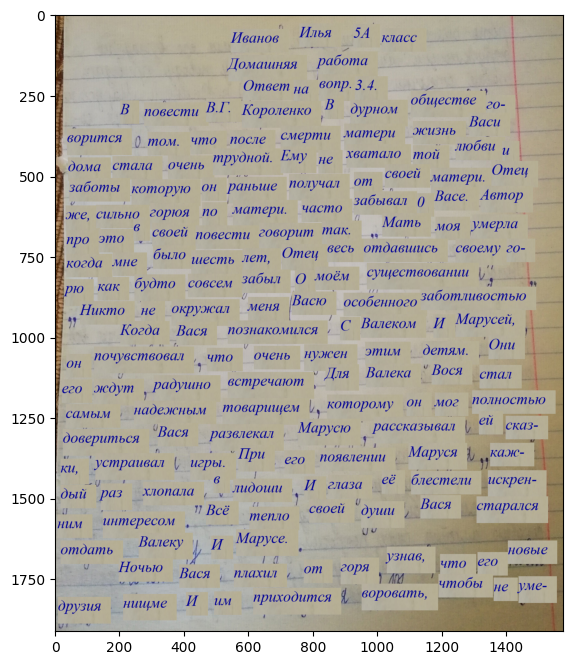

In [13]:
from PIL import Image, ImageDraw, ImageFont

def textsize(text, font):
    im = Image.new(mode="P", size=(0, 0))
    draw = ImageDraw.Draw(im)
    _, _, width, height = draw.textbbox((0, 0), text=text, font=font)
    return width, height

# Загрузите изображение Plashka.png в качестве фона
background = Image.open('config/Plashka.png')

# Прочитайте изображение
image = cv2.imread(IMG_PATH)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Создайте пустое изображение для наложения текста
final_image = Image.fromarray(image)

# Наложите фон на каждый кусочек текста
font_path = "config/timesi.ttf"
font_size = 48
font_color = (0, 0, 150)
padding = 30  # Добавим 20 пикселей для ширины и высоты

for idx, coordinates in enumerate(letter_coordinates):
    text = preds[idx]  # Предполагается, что preds - это список символов
    text_coordinates = (coordinates[0], coordinates[1])

    # Создайте объект для рисования на изображении
    draw = ImageDraw.Draw(final_image)

    # Загрузите шрифт
    font = ImageFont.truetype(font_path, font_size)

    # Наложите фон на кусочек текста
    text_width, text_height = textsize(text, font=font)
    background_resized = background.resize((text_width + padding, text_height + padding))
    final_image.paste(background_resized, text_coordinates, mask=background_resized)

# Наложите текст на изображение
for idx, coordinates in enumerate(letter_coordinates):
    text = preds[idx]  # Предполагается, что preds - это список символов
    text_coordinates = (coordinates[0], coordinates[1])

    # Создайте объект для рисования на изображении
    draw = ImageDraw.Draw(final_image)

    # Загрузите шрифт
    font = ImageFont.truetype(font_path, font_size)

    # Наложите текст на изображение
    draw.text(text_coordinates, text, font=font, fill=font_color)

# Преобразуйте изображение в массив numpy
final_image_np = np.array(final_image)

# Отобразите изображение
plt.figure(figsize=(8, 8))
plt.imshow(final_image_np)
final_image.save('temp_image.png')
plt.show()

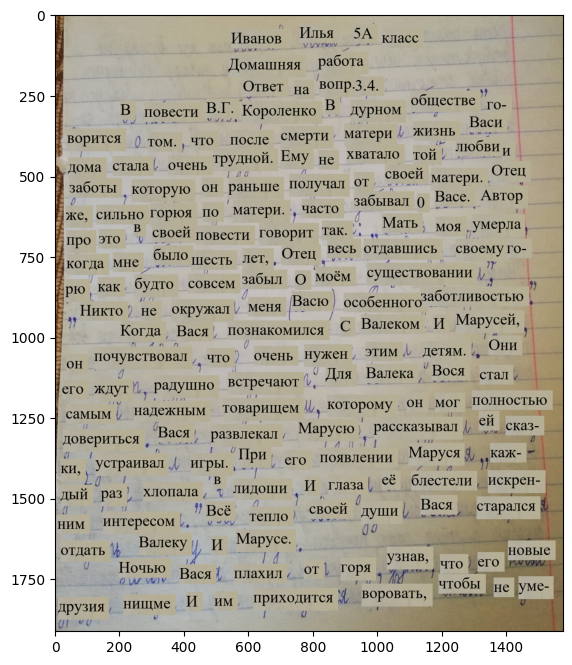

In [14]:
from PIL import Image, ImageDraw, ImageFont

# Загрузите изображение Plashka.png в качестве фона
background = Image.open('config/Plashka.png')

# Прочитайте изображение
image = cv2.imread(IMG_PATH)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Создайте пустое изображение для наложения текста
final_image = Image.fromarray(image)

# Наложите фон на каждый кусочек текста
font_path = "config/times.ttf"
font_size = 50
font_color = (0, 0, 0)
padding = 15  # Добавим 15 пикселей для ширины и высоты

for idx, coordinates in enumerate(letter_coordinates):
    text = preds[idx]  # Предполагается, что preds - это список символов
    text_coordinates = (coordinates[0], coordinates[1])

    # Создайте объект для рисования на изображении
    draw = ImageDraw.Draw(final_image)

    # Загрузите шрифт
    font = ImageFont.truetype(font_path, font_size)

    # Наложите фон на кусочек текста
    text_width, text_height = textsize(text, font=font)
    background_resized = background.resize((text_width + padding, text_height + padding))
    final_image.paste(background_resized, text_coordinates, mask=background_resized)

# Наложите текст на изображение
for idx, coordinates in enumerate(letter_coordinates):
    text = preds[idx]  # Предполагается, что preds - это список символов
    text_coordinates = (coordinates[0], coordinates[1])

    # Создайте объект для рисования на изображении
    draw = ImageDraw.Draw(final_image)

    # Загрузите шрифт
    font = ImageFont.truetype(font_path, font_size)

    # Наложите текст на изображение
    draw.text(text_coordinates, text, font=font, fill=font_color)

# Преобразуйте изображение в массив numpy
final_image_np = np.array(final_image)

# Отобразите изображение
plt.figure(figsize=(8, 8))
plt.imshow(final_image_np)
final_image.save('temp_image.png')
plt.show()

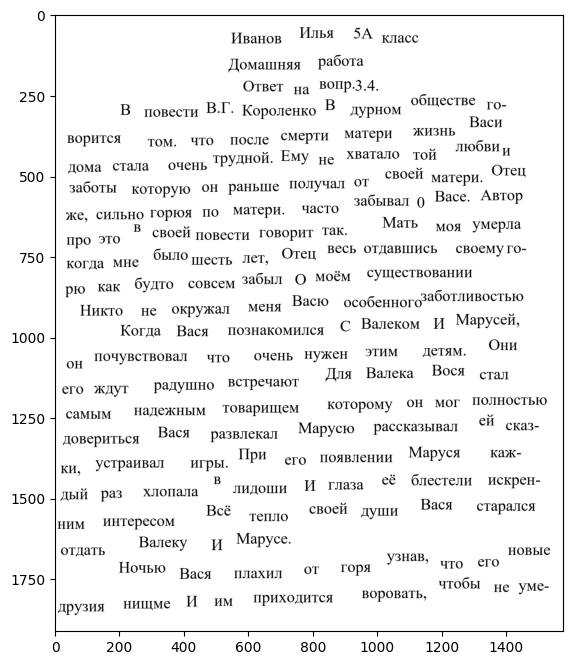

In [15]:
from PIL import Image, ImageDraw, ImageFont

# Прочитайте изображение
image = cv2.imread(IMG_PATH)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Создайте пустое изображение для наложения текста
final_image = Image.new('RGB', (image.shape[1], image.shape[0]), color=(255, 255, 255))

# Наложите фон на каждый кусочек текста
font_path = "config/times.ttf"
font_size = 50
font_color = (0, 0, 0)
padding = 15  # Добавим 15 пикселей для ширины и высоты

for idx, coordinates in enumerate(letter_coordinates):
    text = preds[idx]  # Предполагается, что preds - это список символов
    text_coordinates = (coordinates[0], coordinates[1])

    # Создайте объект для рисования на изображении
    draw = ImageDraw.Draw(final_image)

    # Загрузите шрифт
    font = ImageFont.truetype(font_path, font_size)

# Наложите текст на изображение
for idx, coordinates in enumerate(letter_coordinates):
    text = preds[idx]  # Предполагается, что preds - это список символов
    text_coordinates = (coordinates[0], coordinates[1])

    # Создайте объект для рисования на изображении
    draw = ImageDraw.Draw(final_image)

    # Загрузите шрифт
    font = ImageFont.truetype(font_path, font_size)

    # Наложите текст на изображение
    draw.text(text_coordinates, text, font=font, fill=font_color)

# Преобразуйте изображение в массив numpy
final_image_np = np.array(final_image)

# Отобразите изображение
plt.figure(figsize=(8, 8))
plt.imshow(final_image_np)
#plt.savefig('temp_image.png', bbox_inches='tight', pad_inches=0)
final_image.save('temp_image.png')
plt.show()

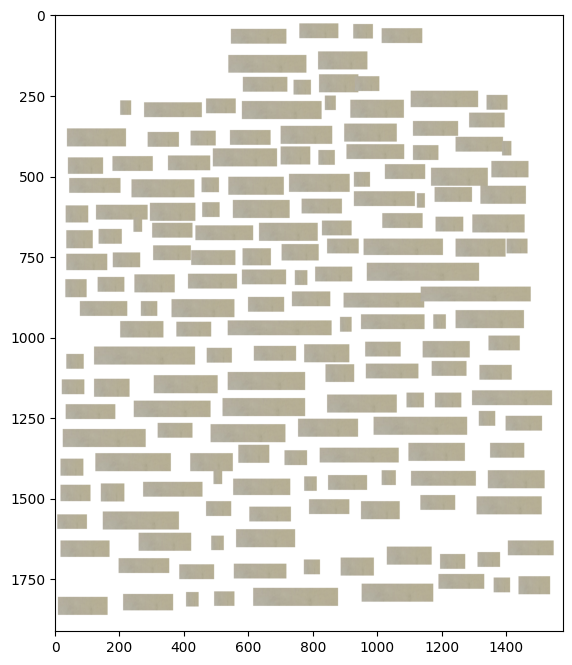

In [16]:
from PIL import Image, ImageDraw, ImageFont

# Загрузите изображение Plashka.png в качестве фона
background = Image.open('config/Plashka.png')

# Прочитайте изображение
image = cv2.imread(IMG_PATH)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Создайте пустое изображение для наложения текста
final_image = Image.new('RGB', (image.shape[1], image.shape[0]), color=(255, 255, 255))

# Наложите текст на изображение для каждой пары координат
font_path = "config/timesbd.ttf"
font_size = 50
font_color = (0, 0, 0)

for idx, coordinates in enumerate(letter_coordinates):
    text = preds[idx]  # Предполагается, что preds - это список символов
    text_coordinates = (coordinates[0], coordinates[1])

    # Создайте объект для рисования на изображении
    draw = ImageDraw.Draw(final_image)

    # Загрузите шрифт
    font = ImageFont.truetype(font_path, font_size)

    # Наложите текст на изображение
    draw.text(text_coordinates, text, font=font, fill=font_color)

    # Наложите фон на кусочек текста
    text_width, text_height = textsize(text, font=font)
    background_resized = background.resize((text_width, text_height))
    final_image.paste(background_resized, text_coordinates, mask=background_resized)

# Преобразуйте изображение в массив numpy
final_image_np = np.array(final_image)

# Отобразите изображение
plt.figure(figsize=(8, 8))
plt.imshow(final_image_np)
plt.savefig('temp_image.png', bbox_inches='tight', pad_inches=0)
plt.show()

In [17]:
!pip install python-docx
from docx import Document
from docx.shared import Inches
def save_text_to_word(texts, output_file, image_path):
    doc = Document()
    doc.add_picture(IMG_PATH, width=Inches(7), height=Inches(9))
    doc.add_picture(image_path, width=Inches(7), height=Inches(9))
    paragraph = doc.add_paragraph()
    for text in texts:
        paragraph.add_run(text + " ")
    doc.save(output_file)

output_file = 'output.docx'

save_text_to_word(preds, output_file, 'temp_image.png')

Defaulting to user installation because normal site-packages is not writeable


In [18]:
import nltk
import string
import pymorphy2

# загружаем словари и правила для pymorphy2
morph = pymorphy2.MorphAnalyzer()

# загружаем русский язык для NLTK
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')
nltk.download('words')
nltk.download('maxent_ne_chunker')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Илья\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Илья\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to
[nltk_data]     C:\Users\Илья\AppData\Roaming\nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Илья\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\Илья\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Илья\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-dat

True

In [19]:
def extract_text_from_docx(docx_file):
    doc = Document(docx_file)
    text = ""
    for paragraph in doc.paragraphs:
        text += paragraph.text + "\n"
    return text

docx_file = 'output.docx'
text = extract_text_from_docx(docx_file)
print(text)
# токенизируем текст и удаляем пунктуацию
tokens = nltk.word_tokenize(text)
tokens = [word for word in tokens if word.isalnum()]



Иванов Илья 5А класс Домашняя работа Ответ на вопр. 3.4. В повести В.Г. Короленко В дурном обществе го- ворится том. что после смерти матери жизнь Васи дома стала очень трудной. Ему не хватало той любви и заботы которую он раньше получал от своей матери. Отец же, сильно горюя по матери. часто забывал 0 Васе. Автор про это в своей повести говорит так. Мать моя умерла когда мне было шесть лет, Отец весь отдавшись своему го- рю как будто совсем забыл О моём существовании Никто не окружал меня Васю особенного заботливостью Когда Вася познакомился С Валеком И Марусей, он почувствовал что очень нужен этим детям. Они его ждут радушно встречают Для Валека Вося стал самым надежным товарищем которому он мог полностью довериться Вася развлекал Марусю рассказывал ей сказ- ки, устраивал игры. При его появлении Маруся каж- дый раз хлопала в лидоши И глаза её блестели искрен- ним интересом Всё тепло своей души Вася старался отдать Валеку И Марусе. Ночью Вася плахил от горя узнав, что его новые друз